# NUS GenAI Capstone Project

## Objective:
Submit a fully integrated prototype that supports the following:
1. Conversational interface with limited memory
2. Document-based Question Answering using RAG
3. Text-to-image generation with prompt engineering
4. Multi-agent task handling using a controller (Weather, SQL, Recommender)
5. Final technical report on system design, debugging, and improvements

## Setup

In [ ]:
# Import libraries

# === Core Python Libraries ===
import os
import replicate
import sqlite3
import requests
from IPython.display import display, Markdown
from datetime import datetime, timedelta
from typing import TypedDict, Annotated, Optional

# === LangChain 1.0 - Agent Framework ===
from langchain.agents import create_agent
from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage

# === LangGraph 1.0 - State Management & Checkpointing ===
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# === Document Processing & Vector Storage ===
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma

# === Hybrid RAG - BM25 and Ensemble Retrievers ===
from langchain_community.retrievers import BM25Retriever
from langchain_classic.retrievers import EnsembleRetriever, ContextualCompressionRetriever

# === Reranking - Jina AI Cross-Encoder ===
from langchain_community.document_compressors import JinaRerank

In [3]:
# Retrieve API keys from environment variables
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
REPLICATE_API_TOKEN = os.environ.get("REPLICATE_API_TOKEN")
WEATHER_API_KEY = os.environ.get("WEATHER_API_KEY")
JINA_API_KEY = os.environ.get("JINA_API_KEY")

In [4]:
# Prepare Hybrid RAG system for Singapore venue policies
# Load venue policy documents for Marina Bay Sands, Gardens by the Bay, Esplanade, and SG regulations

venue_policy_files = [
    'MBS-Event-Policy.pdf',
    'GBTB-Venue-Guide.pdf',
    'Esplanade-Manual.pdf',
    'SG-Event-Regulations.pdf'
]

# Load all venue policy documents
all_documents = []
for filepath in venue_policy_files:
    loader = PyMuPDFLoader(filepath)
    docs = loader.load()
    if docs:
        all_documents.extend(docs)
        print(f"✅ Loaded {len(docs)} pages from {filepath}")
    else:
        print(f"⚠️ No content extracted from {filepath}")

if not all_documents:
    raise ValueError("No documents loaded. Check PDF files.")

print(f"\n📄 Total pages loaded: {len(all_documents)}")

# Split into chunks optimized for policy documents
# Using smaller chunk_size (1000 vs 2000) for better granularity with policy sections
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(all_documents)
if not chunks:
    raise ValueError("No chunks produced. Check document parsing.")
print(f"📋 Split into {len(chunks)} chunks (1000 char size, 200 overlap)")

# Create embeddings
embedding_model = OpenAIEmbeddings(api_key=OPENAI_API_KEY, model="text-embedding-3-small")
print("✅ Embedding model initialized")

# Create semantic retriever (dense vector search)
vector_store = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_model,
    persist_directory="./venue_policies_chroma_db"
)
semantic_retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})
print("✅ Semantic retriever created (Chroma + OpenAI embeddings)")

# Create BM25 retriever (keyword/sparse search)
bm25_retriever = BM25Retriever.from_documents(chunks)
bm25_retriever.k = 5
print("✅ BM25 retriever created (keyword-based)")

# Combine retrievers with Reciprocal Rank Fusion (RRF)
hybrid_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, semantic_retriever],
    weights=[0.4, 0.6]  # 40% keyword (BM25), 60% semantic
)
print("✅ Hybrid retriever created (BM25 + Semantic with RRF)")
print("   Weights: 40% keyword, 60% semantic")

# Add Jina AI reranker on top of hybrid retrieval (3-stage retrieval)
compressor = JinaRerank(
    model="jina-reranker-v2-base-multilingual",  # Jina Reranker v2 (v3 may not be in API yet)
    top_n=3,  # Return top 3 after reranking
    jina_api_key=JINA_API_KEY
)

reranking_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=hybrid_retriever
)
print("✅ Reranking retriever created (Jina Reranker v2)")
print("   3-stage pipeline: BM25 → Semantic → Jina cross-encoder rerank")

print("\n🎯 Complete retrieval system ready:")
print("   Stage 1: BM25 keyword search (exact matches)")
print("   Stage 2: Semantic vector search (conceptual)")  
print("   Stage 3: Jina AI cross-encoder reranking (relevance)")
print("\n✨ Optimized for venue policy queries with proper nouns, codes, and concepts!")

✅ Loaded 8 pages from MBS-Event-Policy.pdf
✅ Loaded 8 pages from GBTB-Venue-Guide.pdf
✅ Loaded 17 pages from Esplanade-Manual.pdf
✅ Loaded 18 pages from SG-Event-Regulations.pdf

📄 Total pages loaded: 51
📋 Split into 115 chunks (1000 char size, 200 overlap)
✅ Embedding model initialized
✅ Semantic retriever created (Chroma + OpenAI embeddings)
✅ BM25 retriever created (keyword-based)
✅ Hybrid retriever created (BM25 + Semantic with RRF)
   Weights: 40% keyword, 60% semantic
✅ Reranking retriever created (Jina Reranker v2)
   3-stage pipeline: BM25 → Semantic → Jina cross-encoder rerank

🎯 Complete retrieval system ready:
   Stage 1: BM25 keyword search (exact matches)
   Stage 2: Semantic vector search (conceptual)
   Stage 3: Jina AI cross-encoder reranking (relevance)

✨ Optimized for venue policy queries with proper nouns, codes, and concepts!


In [ ]:
# Create enhanced Singapore-focused events database
def setup_database():
    """Initialize the events database with Singapore-focused event planning data."""
    conn = sqlite3.connect('events.db')
    c = conn.cursor()

    # Drop old table if exists (migration)
    c.execute('DROP TABLE IF EXISTS events')
    
    # Create enhanced table schema
    c.execute('''
        CREATE TABLE events (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            category TEXT,
            type TEXT,
            description TEXT,
            
            venue_name TEXT NOT NULL,
            location_address TEXT,
            postal_code TEXT,
            mrt_station TEXT,
            
            date TEXT NOT NULL,
            start_time TEXT,
            end_time TEXT,
            duration_hours REAL,
            
            expected_capacity INTEGER,
            ticket_price TEXT,
            equipment_needs TEXT,
            
            requires_permit INTEGER DEFAULT 0,
            requires_insurance INTEGER DEFAULT 0,
            sound_level_limit TEXT,
            
            wheelchair_accessible INTEGER DEFAULT 1,
            has_assisted_listening INTEGER DEFAULT 0,
            
            weather_dependent INTEGER DEFAULT 0,
            rain_backup_plan TEXT,
            
            organizer TEXT,
            contact_email TEXT,
            booking_url TEXT,
            notes TEXT
        )
    ''')

    today = datetime.now().date()
    def iso(days=0): return (today + timedelta(days=days)).isoformat()

    # Singapore-focused event data with event planning details
    events = [
        # === TODAY (6 events) ===
        # Marina Bay Sands events
        ("Marina Bay Sands Grand Concert", "music", "indoor", 
         "Symphony orchestra performing classical masterpieces in the Grand Ballroom",
         "Marina Bay Sands", "10 Bayfront Ave", "018956", "Bayfront (CE1/DT16)",
         iso(0), "19:30", "22:30", 3.0,
         2000, "$100-$300", "professional_lighting,sound_system,stage,formal_seating",
         1, 1, "No specific limit (indoor venue)",
         1, 1,
         0, None,
         "MBS Events Team", "events@marinabaysands.com", "https://marinabaysands.com/events",
         "Black tie optional. Professional photography allowed but NO tripods per MBS policy. Drone photography strictly prohibited."),
        
        ("MBS Tech Innovation Summit", "tech", "indoor",
         "Startup pitches and product demonstrations in Convention Centre",
         "Marina Bay Sands", "10 Bayfront Ave", "018956", "Bayfront (CE1/DT16)",
         iso(0), "09:00", "18:00", 9.0,
         3000, "$50-$200", "projectors,microphones,stage,exhibition_booths",
         1, 1, "No specific limit (indoor venue)",
         1, 1,
         0, None,
         "TechSG", "contact@techsg.org", "https://techsg.org/summit",
         "Business casual attire. Equipment setup requires prior approval from MBS events team."),
        
        # Gardens by the Bay events  
        ("Gardens by the Bay Food Festival", "food", "outdoor",
         "Outdoor food carnival featuring local and international cuisine",
         "Gardens by the Bay", "18 Marina Gardens Dr", "018953", "Bayfront (CE1/DT16)",
         iso(0), "11:00", "21:00", 10.0,
         5000, "Free entry", "tents,food_stalls,tables,waste_management,amplified_sound",
         1, 1, "85dBA daytime (9am-6pm), 80dBA evening (6pm-10pm)",
         1, 0,
         1, "Move food stalls to covered Garden Pavilion. Event will proceed with modifications.",
         "GBTB Events", "events@gardensbythebay.com.sg", "https://gardensbythebay.com.sg/food-festival",
         "Sound level restrictions strictly enforced per GBTB policy. No amplified music between 10pm-9am. Background music max 65-70dBA."),
        
        # Esplanade events
        ("Esplanade Contemporary Art Exhibition", "art", "indoor",
         "Modern art showcase in the Concourse Gallery",
         "Esplanade", "1 Esplanade Dr", "038981", "Esplanade (CC3)",
         iso(0), "10:00", "20:00", 10.0,
         800, "Free", "gallery_lighting,display_stands,security",
         1, 0, "No specific limit (indoor venue)",
         1, 0,
         0, None,
         "Esplanade Co", "info@esplanade.com", "https://esplanade.com/exhibitions",
         "Photography allowed without flash. Wheelchair accessible via direct MRT connection. Companion seating available."),
        
        # Singapore Botanic Gardens
        ("Botanic Gardens Photography Workshop", "art", "outdoor",
         "Learn nature photography with professional guidance",
         "Singapore Botanic Gardens", "1 Cluny Rd", "259569", "Botanic Gardens (CC19/DT9)",
         iso(0), "09:00", "12:00", 3.0,
         25, "$150", "tripods_allowed,cameras,photography_equipment",
         1, 1, "Quiet environment required",
         1, 0,
         1, "Reschedule to next available weekend. Full refunds provided.",
         "SG Photo Society", "workshops@sgphoto.org", "https://sgphoto.org/workshops",
         "Tripods allowed for this workshop. No flash photography near sensitive plants. Small group size for personalized instruction."),
        
        # Other Singapore venue
        ("Sentosa Beach Yoga Session", "sports", "outdoor",
         "Morning yoga and meditation on Siloso Beach",
         "Siloso Beach Sentosa", "51 Imbiah Walk", "099538", "HarbourFront (NE1/CC29)",
         iso(0), "07:00", "08:30", 1.5,
         50, "$30", "yoga_mats,portable_speaker,shade_tent",
         1, 1, "Ambient sound only (no amplification needed)",
         1, 0,
         1, "Move to covered pavilion nearby. Event proceeds unless heavy rain.",
         "Sentosa Wellness", "wellness@sentosa.com.sg", "https://sentosa.com.sg/wellness",
         "Bring your own mat or rent on-site. Suitable for all fitness levels. Weather-dependent outdoor activity."),
        
        # === TOMORROW (6 events) ===
        ("Esplanade Jazz Under the Stars", "music", "outdoor",
         "Evening jazz performance at the Outdoor Theatre",
         "Esplanade", "1 Esplanade Dr", "038981", "Esplanade (CC3)",
         iso(1), "19:00", "22:00", 3.0,
         1500, "$40-$80", "sound_system,stage_lighting,outdoor_seating",
         1, 1, "85dBA limit for outdoor performances",
         1, 1,
         1, "Move to Concert Hall (indoor). Ticketholders automatically transferred.",
         "Esplanade Co", "info@esplanade.com", "https://esplanade.com/jazz",
         "Part of annual jazz series. Wheelchair accessible seating available. Assisted listening devices provided on request."),
        
        ("Marina Bay Sands Art Bazaar", "art", "indoor",
         "Pop-up marketplace for local artists and designers",
         "Marina Bay Sands", "10 Bayfront Ave", "018956", "Bayfront (CE1/DT16)",
         iso(1), "10:00", "19:00", 9.0,
         1200, "Free entry", "exhibition_booths,display_lighting,payment_terminals",
         1, 1, "No specific limit (indoor venue)",
         1, 0,
         0, None,
         "ArtSG Collective", "hello@artsg.com", "https://artsg.com/bazaar",
         "Photography allowed. No professional equipment or tripods per MBS policy. Support local artists and designers."),
        
        ("Gardens by the Bay Nature Walk", "cultural", "outdoor",
         "Guided tour exploring biodiversity and conservation",
         "Gardens by the Bay", "18 Marina Gardens Dr", "018953", "Bayfront (CE1/DT16)",
         iso(1), "08:00", "10:00", 2.0,
         40, "$25", "portable_microphone,umbrellas,water_station",
         0, 1, "Quiet environment (no amplified sound)",
         1, 0,
         1, "Reschedule to next available date. Participants notified via email.",
         "GBTB Education", "education@gardensbythebay.com.sg", "https://gardensbythebay.com.sg/learn",
         "Family-friendly activity. Plant protection rules apply - no touching of plants. Small group for personalized experience."),
        
        ("Clarke Quay Night Market", "food", "outdoor",
         "Evening food and craft market along Singapore River",
         "Clarke Quay", "3 River Valley Rd", "179024", "Clarke Quay (NE5)",
         iso(1), "17:00", "23:00", 6.0,
         3000, "Free entry", "market_stalls,lighting,waste_bins,background_music",
         1, 1, "75dBA limit after 10pm (residential area nearby)",
         1, 0,
         1, "Move to covered walkways. Event continues unless severe weather.",
         "Clarke Quay Merchants", "events@clarkequay.com.sg", "https://clarkequay.com.sg/night-market",
         "Sound restrictions enforced after 10pm due to nearby residences. Public Entertainment License in place. Accessible via MRT."),
        
        ("National Museum Singapore Heritage Tour", "cultural", "indoor",
         "Guided tour of Singapore's history and heritage exhibits",
         "National Museum of Singapore", "93 Stamford Rd", "178897", "Bras Basah (CC2)",
         iso(1), "14:00", "16:00", 2.0,
         30, "$20", "audio_guide_system,accessibility_aids",
         0, 0, "Quiet museum environment",
         1, 1,
         0, None,
         "National Heritage Board", "nhb_contact@nhb.gov.sg", "https://nationalmuseum.sg/tours",
         "Photography allowed in most areas (no flash). Wheelchair accessible. Assisted listening devices available. Air-conditioned comfort."),
        
        ("Marina Barrage Kite Festival", "sports", "outdoor",
         "Family kite flying event with kite-making workshops",
         "Marina Barrage", "8 Marina Gardens Dr", "018951", "Marina Bay (CE2)",
         iso(1), "15:00", "18:00", 3.0,
         500, "Free", "kite_materials,workshop_tent,first_aid_station",
         1, 1, "Outdoor recreational activity (no amplification)",
         1, 0,
         1, "Cancel if heavy rain or strong winds (>20km/h). Full refund for workshop fees.",
         "PUB Recreation", "recreation@pub.gov.sg", "https://pub.gov.sg/marina-barrage",
         "Highly weather-dependent. Suitable for children. Kites provided or bring your own. Wide open space with great views."),
        
        # === DAYS 2-6 (8 more events) ===
        ("Esplanade Theatre: Contemporary Dance", "cultural", "indoor",
         "Modern dance performance in the Theatre Studio",
         "Esplanade", "1 Esplanade Dr", "038981", "Esplanade (CC3)",
         iso(2), "20:00", "22:00", 2.0,
         200, "$35-$65", "stage_lighting,sound_system,seating",
         1, 1, "No specific limit (indoor venue)",
         1, 1,
         0, None,
         "Esplanade Co", "info@esplanade.com", "https://esplanade.com/dance",
         "Intimate theatre setting. Wheelchair companion seating available. No photography during performance."),
        
        ("MBS Weekend Food Expo", "food", "indoor",
         "International cuisine showcase in the Expo Hall",
         "Marina Bay Sands", "10 Bayfront Ave", "018956", "Bayfront (CE1/DT16)",
         iso(3), "11:00", "20:00", 9.0,
         4000, "$15 entry", "food_booths,tasting_stations,dining_area",
         1, 1, "No specific limit (indoor venue)",
         1, 0,
         0, None,
         "MBS Events", "events@marinabaysands.com", "https://marinabaysands.com/food-expo",
         "Family-friendly event. Wheelchair accessible. Multiple food vendors from around the world."),
        
        ("Botanic Gardens Sunset Concert", "music", "outdoor",
         "Classical music performance at Symphony Lake",
         "Singapore Botanic Gardens", "1 Cluny Rd", "259569", "Botanic Gardens (CC19/DT9)",
         iso(3), "18:00", "20:00", 2.0,
         800, "Free", "sound_system,outdoor_seating,stage",
         1, 1, "75dBA limit (evening outdoor performance)",
         1, 0,
         1, "Move to indoor Visitor Centre auditorium. Reduced capacity (200 seats).",
         "SG Symphony", "info@sgsymphony.com", "https://sgsymphony.com/botanic",
         "Bring picnic mats. No tripods allowed for photography. Sound restrictions enforced to protect garden tranquility."),
        
        ("GBTB Floral Fantasy Workshop", "art", "indoor",
         "Flower arrangement and design workshop",
         "Gardens by the Bay", "18 Marina Gardens Dr", "018953", "Bayfront (CE1/DT16)",
         iso(4), "14:00", "16:30", 2.5,
         20, "$80", "workbenches,floral_materials,tools,aprons",
         0, 1, "Workshop environment (no noise restrictions)",
         1, 0,
         0, None,
         "GBTB Education", "education@gardensbythebay.com.sg", "https://gardensbythebay.com.sg/workshops",
         "All materials provided. Suitable for beginners. Take home your creation. Small class size for hands-on learning."),
        
        ("Esplanade Children's Festival", "cultural", "indoor",
         "Interactive performances and activities for children",
         "Esplanade", "1 Esplanade Dr", "038981", "Esplanade (CC3)",
         iso(4), "10:00", "17:00", 7.0,
         1000, "$10-$30", "activity_stations,performance_areas,safety_equipment",
         1, 1, "No specific limit (indoor venue)",
         1, 1,
         0, None,
         "Esplanade Co", "info@esplanade.com", "https://esplanade.com/children",
         "Family-friendly. Wheelchair accessible throughout. Parent supervision required. Stroller parking available."),
        
        ("Marina Bay Sands Wedding Fair", "cultural", "indoor",
         "Wedding planning expo with vendors and consultations",
         "Marina Bay Sands", "10 Bayfront Ave", "018956", "Bayfront (CE1/DT16)",
         iso(5), "12:00", "19:00", 7.0,
         2500, "Free entry", "exhibition_booths,consultation_areas,stage_for_fashion_show",
         1, 1, "No specific limit (indoor venue)",
         1, 0,
         0, None,
         "Wedding SG", "info@weddingsg.com", "https://weddingsg.com/fair",
         "Meet wedding vendors. Fashion show at 3pm and 6pm. Photography demos. Equipment restrictions per MBS policy apply."),
        
        ("GBTB Evening Garden Walk", "cultural", "outdoor",
         "Guided evening tour of illuminated gardens",
         "Gardens by the Bay", "18 Marina Gardens Dr", "018953", "Bayfront (CE1/DT16)",
         iso(5), "19:30", "21:00", 1.5,
         60, "$30", "portable_microphone,flashlights,water",
         0, 1, "Quiet tour (minimal amplification)",
         1, 0,
         1, "Event proceeds in light rain. Cancelled only in heavy rain/thunderstorm. Full refund if cancelled.",
         "GBTB Tours", "tours@gardensbythebay.com.sg", "https://gardensbythebay.com.sg/tours",
         "See gardens in evening lights. Small group tour. Photography allowed without tripods. Comfortable walking shoes recommended."),
        
        ("Esplanade Rooftop Cinema", "cultural", "outdoor",
         "Open-air movie screening under the stars",
         "Esplanade", "1 Esplanade Dr", "038981", "Esplanade (CC3)",
         iso(6), "20:00", "22:30", 2.5,
         300, "$20", "projector,sound_system,outdoor_seating,blankets",
         1, 1, "Sound directed away from residential areas",
         1, 0,
         1, "Move to indoor Recital Studio. Smaller screen but full experience maintained.",
         "Esplanade Co", "info@esplanade.com", "https://esplanade.com/cinema",
         "Bring cushions/blankets or rent on-site. Light refreshments available. Weather-dependent screening. Amazing skyline views.")
    ]

    # Insert data
    c.executemany('''
        INSERT INTO events (
            name, category, type, description,
            venue_name, location_address, postal_code, mrt_station,
            date, start_time, end_time, duration_hours,
            expected_capacity, ticket_price, equipment_needs,
            requires_permit, requires_insurance, sound_level_limit,
            wheelchair_accessible, has_assisted_listening,
            weather_dependent, rain_backup_plan,
            organizer, contact_email, booking_url, notes
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', events)

    conn.commit()
    
    # Print summary
    event_count = len(events)
    venues = set(e[4] for e in events)
    print(f"✅ Database setup completed successfully!")
    print(f"   📊 {event_count} Singapore events added")
    print(f"   🏛️  Venues: {', '.join(sorted(venues))}")
    print(f"   📅 Date range: Today through next 7 days")
    print(f"   🎯 Enhanced with event planning metadata")
    
    conn.close()

# Run setup
setup_database()

## Implementation

In [6]:
@tool
def retrieve_venue_policies(query: str) -> str:
    """
    Retrieve venue policies, restrictions, and requirements from Singapore event venues.
    Uses 3-stage retrieval: BM25 + semantic + Jina Reranker v2 for maximum relevance.
    
    Covers:
    - Photography/equipment restrictions (tripods, drones, professional gear)
    - Sound level limits and amplified music regulations  
    - Capacity limits and safety requirements
    - Accessibility features (wheelchair access, assisted listening)
    - Insurance requirements and liability coverage
    - MRT access, postal codes, and parking information
    - Technical specifications (stage dimensions, lighting, sound systems)
    
    Args:
        query: Question about venue policies (e.g., "tripod policy at Marina Bay Sands")
    
    Returns:
        Relevant policy excerpts with source attribution (venue name and page number)
    """
    # Use reranking retriever for best results
    retrieved_docs = reranking_retriever.invoke(query)
    
    # Format with source attribution for transparency
    formatted = []
    for doc in retrieved_docs:
        source = doc.metadata.get('source', 'Unknown')
        page = doc.metadata.get('page', '?')
        # Extract just the filename without path
        source_name = source.split('\\')[-1].split('/')[-1].replace('.pdf', '')
        formatted.append(f"[{source_name}, p.{page}]\n{doc.page_content}\n")
    
    return "\n".join(formatted)

# Store pending image requests for approval
pending_image_requests = {}

@tool
def request_image_generation(prompt: str, seed: int = 42, steps: int = 30) -> str:
    """
    Request to generate an image using Replicate API.
    This will ask for user approval before actually generating the image (costs money).
    
    Args:
        prompt: Description of the image to generate
        seed: Random seed for reproducibility (default: 42)
        steps: Number of generation steps (default: 30)
    
    Returns:
        A message indicating approval is needed
    """
    import uuid
    request_id = str(uuid.uuid4())
    pending_image_requests[request_id] = {
        "prompt": prompt,
        "seed": seed,
        "steps": steps
    }
    return f"🖼️ Image generation requested for: '{prompt}'\n\n⚠️ This will cost money via Replicate API. Please approve by calling 'approve_image_generation' with request_id: {request_id}"

@tool
def approve_image_generation(request_id: str) -> str:
    """
    Approve and execute a pending image generation request.
    
    Args:
        request_id: The ID of the pending image request to approve
    
    Returns:
        URL of the generated image or error message
    """
    if request_id not in pending_image_requests:
        return "⚠️ Invalid or expired request ID. No pending image generation found."
    
    request = pending_image_requests.pop(request_id)
    prompt = request["prompt"]
    seed = request["seed"]
    steps = request["steps"]
    
    try:
        output = replicate.run(
            "stability-ai/stable-diffusion-3.5-medium",
            input={"prompt": prompt, "seed": seed, "steps": steps}
        )

        # Handle unexpected response formats
        if isinstance(output, list):
            return output[0] if output else "⚠️ No image generated."
        elif hasattr(output, "url"):
            return output.url
        else:
            return str(output)
    except replicate.exceptions.ModelError as e:
        return f"⚠️ Image generation model error: {e}"
    except replicate.exceptions.ReplicateError as e:
        return f"⚠️ Replicate API error: {e}"
    except Exception as e:
        return f"⚠️ Unexpected image generation error: {e}"

@tool
def get_current_date() -> str:
    """
    Returns today's date in ISO format (YYYY-MM-DD).
    Use this tool when you need to know the current date for querying events or making date-based recommendations.
    """
    return datetime.now().date().isoformat()

In [7]:
@tool
def get_weather(location: str = 'Singapore') -> str:
    """
    Retrieve real-time weather data via the WeatherAPI.
    Takes a location as input and returns weather information including temperature and conditions.
    """
    url = "http://api.weatherapi.com/v1/current.json"
    params = {"key": WEATHER_API_KEY, "q": location, "aqi": "no"}
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        # Extract relevant weather information
        location_name = data['location']['name']
        country = data['location']['country']
        temp_c = data['current']['temp_c']
        condition = data['current']['condition']['text']
        
        return f"Weather in {location_name}, {country}: {temp_c}°C, {condition}"
    except requests.exceptions.Timeout:
        return f"⚠️ Weather API request timed out for {location}."
    except requests.exceptions.ConnectionError:
        return f"⚠️ Network connection failed while fetching weather for {location}."
    except requests.exceptions.HTTPError as e:
        return f"⚠️ Weather API HTTP error: {e}"
    except KeyError:
        return f"⚠️ Unexpected weather data format for {location}."
    except Exception as e:
        return f"⚠️ Unexpected weather retrieval error: {e}"

In [ ]:
@tool
def get_events(date: str, event_type: str | None = None, category: str | None = None, venue_name: str | None = None) -> str:
    """
    Retrieves Singapore event data by querying the enhanced events database.
    All events are in Singapore with detailed event planning information.
    
    Args:
        date: Event date in YYYY-MM-DD format
        event_type: Optional filter by type ('indoor', 'outdoor', 'hybrid')
        category: Optional filter by category ('music', 'food', 'art', 'tech', 'cultural', 'sports')
        venue_name: Optional filter by venue (e.g., 'Marina Bay Sands', 'Esplanade', 'Gardens by the Bay')
    
    Returns:
        Formatted string with event details including venue, timing, accessibility, weather impact, and booking info
    """
    conn = sqlite3.connect('events.db')
    c = conn.cursor()
    
    # Build query dynamically based on filters
    query = 'SELECT * FROM events WHERE date=?'
    params = [date]
    
    if event_type:
        query += ' AND type=?'
        params.append(event_type)
    
    if category:
        query += ' AND category=?'
        params.append(category)
        
    if venue_name:
        query += ' AND venue_name LIKE ?'
        params.append(f'%{venue_name}%')
    
    c.execute(query, params)
    events = c.fetchall()
    conn.close()
    
    if not events:
        filter_desc = f" on {date}"
        if event_type:
            filter_desc += f", type={event_type}"
        if category:
            filter_desc += f", category={category}"
        if venue_name:
            filter_desc += f", venue={venue_name}"
        return f"No events found in Singapore{filter_desc}"
    
    # Format events with enhanced details
    formatted_events = []
    for event in events:
        (event_id, name, cat, etype, desc,
         venue, addr, postal, mrt,
         edate, start_time, end_time, duration,
         capacity, price, equipment,
         req_permit, req_insurance, sound_limit,
         wheelchair, assisted_listening,
         weather_dep, rain_backup,
         organizer, email, url, notes) = event
        
        # Build comprehensive event description
        event_str = f"📅 **{name}** ({cat}, {etype})\n"
        event_str += f"   📍 Venue: {venue} @ {addr} ({postal})\n"
        event_str += f"   🚇 MRT: {mrt}\n"
        event_str += f"   ⏰ Time: {start_time} - {end_time} ({duration}h)\n"
        event_str += f"   💰 Price: {price}\n"
        event_str += f"   👥 Capacity: {capacity}\n"
        
        # Event planning details
        if equipment:
            event_str += f"   🎬 Equipment: {equipment}\n"
        if req_permit or req_insurance:
            reqs = []
            if req_permit:
                reqs.append("permit")
            if req_insurance:
                reqs.append("insurance")
            event_str += f"   📋 Requirements: {', '.join(reqs)}\n"
        if sound_limit:
            event_str += f"   🔊 Sound limit: {sound_limit}\n"
        
        # Accessibility
        access_features = []
        if wheelchair:
            access_features.append("wheelchair accessible")
        if assisted_listening:
            access_features.append("assisted listening")
        if access_features:
            event_str += f"   ♿ Accessibility: {', '.join(access_features)}\n"
        
        # Weather impact
        if weather_dep and rain_backup:
            event_str += f"   🌧️  Weather-dependent. Rain plan: {rain_backup}\n"
        elif weather_dep:
            event_str += f"   🌧️  Weather-dependent event (outdoor)\n"
        
        # Contact & booking
        event_str += f"   📧 Organizer: {organizer} ({email})\n"
        if url:
            event_str += f"   🔗 Booking: {url}\n"
        if notes:
            event_str += f"   ℹ️  Notes: {notes}\n"
        
        formatted_events.append(event_str)
    
    return "\n\n".join(formatted_events)

In [9]:
# Recommendation Tool - Simple LLM Chain

# Create prompt template for recommendations
recommendation_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful event recommender. Consider the weather conditions and suggest suitable events. 
    For outdoor events, consider the temperature and weather conditions. Be specific about why you recommend certain events over others. 
    Keep your response concise but informative. 
    If event data is unavailable, politely request the user for additional event-related information.
    If weather data is unavailable, provide a balanced mix of indoor and outdoor suggestions."""),
    ("user", "{weather_and_event_data}")
])

# Create a simple chain: prompt → LLM
recommendation_chain = recommendation_prompt | ChatOpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)

@tool
def recommend_events(weather_and_event_data: str) -> str:
    """
    Synthesize weather and event data into context-aware event recommendations.
    Takes combined weather and event information as input and returns personalized suggestions.
    
    Args:
        weather_and_event_data: Combined string containing weather conditions and available events
    
    Returns:
        A concise, personalized recommendation based on weather and events
    """
    try:
        # Invoke the chain with the input data
        result = recommendation_chain.invoke({"weather_and_event_data": weather_and_event_data})
        return result.content
    except Exception as e:
        return f"⚠️ Recommendation failed: {e}"

### LangGraph State Schemas

In [10]:
# State Schemas for LangGraph

# 1. Recommendation State - for parallel weather + events workflow
class RecommendationState(TypedDict):
    """State for event recommendation workflow with parallel execution."""
    messages: Annotated[list[BaseMessage], add_messages]
    current_date: str
    location: str
    country: str
    event_type: Optional[str]
    weather_data: str
    event_data: str
    recommendations: str

# 2. Main Agent State - for overall conversation flow
class MainAgentState(TypedDict):
    """Main agent state with conversation history."""
    messages: Annotated[list[BaseMessage], add_messages]

# 3. Image Generation State - replaces global pending_image_requests dict
class ImageRequestState(TypedDict):
    """State for managing image generation requests with approval workflow."""
    messages: Annotated[list[BaseMessage], add_messages]
    request_id: str
    prompt: str
    seed: int
    steps: int
    status: str  # "pending", "approved", "completed", "rejected"
    image_url: Optional[str]

print("✅ State schemas defined for LangGraph")

✅ State schemas defined for LangGraph


### Recommendation Subgraph - Parallel Execution

In [11]:
# Recommendation Subgraph Nodes - Explicit workflow with parallel execution

def get_date_node(state: RecommendationState) -> dict:
    """Node 1: Get current date."""
    current_date = datetime.now().date().isoformat()
    print(f"📅 Date retrieved: {current_date}")
    return {"current_date": current_date}

def get_weather_node(state: RecommendationState) -> dict:
    """Node 2: Fetch weather data (runs in parallel with get_events_node)."""
    location = state.get("location", "Singapore")
    
    url = "http://api.weatherapi.com/v1/current.json"
    params = {"key": WEATHER_API_KEY, "q": location, "aqi": "no"}
    
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        location_name = data['location']['name']
        country = data['location']['country']
        temp_c = data['current']['temp_c']
        condition = data['current']['condition']['text']
        
        weather_data = f"Weather in {location_name}, {country}: {temp_c}°C, {condition}"
        print(f"🌤️  Weather fetched: {weather_data}")
        return {"weather_data": weather_data}
    
    except Exception as e:
        weather_data = f"⚠️ Weather unavailable for {location}: {e}"
        print(weather_data)
        return {"weather_data": weather_data}

def get_events_node(state: RecommendationState) -> dict:
    """Node 3: Query events from database (runs in parallel with get_weather_node)."""
    date = state["current_date"]
    event_type = state.get("event_type")
    country = state.get("country", "Singapore")
    
    conn = sqlite3.connect('events.db')
    c = conn.cursor()
    
    if event_type:
        c.execute('SELECT * FROM events WHERE date=? AND type=? AND country=?', 
                  (date, event_type, country))
    else:
        c.execute('SELECT * FROM events WHERE date=? AND country=?', (date, country))
    
    events = c.fetchall()
    conn.close()
    
    if not events:
        event_data = f"No events found in {country} on {date}" + \
                     (f" ({event_type} type)" if event_type else " (all types)")
        print(f"📋 {event_data}")
        return {"event_data": event_data}
    
    # Format events
    formatted_events = []
    for event in events:
        event_id, name, etype, desc, location, ecountry, edate = event
        formatted_events.append(
            f"- {name} ({etype}): {desc}. Location: {location}. Date: {edate}"
        )
    
    event_data = "\n".join(formatted_events)
    print(f"📋 Events retrieved: {len(events)} events found")
    return {"event_data": event_data}

def synthesize_recommendations_node(state: RecommendationState) -> dict:
    """Node 4: Synthesize weather + events into recommendations (replaces recommend_events tool)."""
    weather_data = state.get("weather_data", "Weather data unavailable")
    event_data = state.get("event_data", "Event data unavailable")
    
    # Combine data for LLM synthesis
    combined_data = f"""**Weather Information:**
{weather_data}

**Available Events:**
{event_data}"""
    
    # Use the existing recommendation chain
    try:
        result = recommendation_chain.invoke({"weather_and_event_data": combined_data})
        recommendations = result.content
        print(f"✅ Recommendations synthesized")
        
        # Add as AI message
        return {
            "recommendations": recommendations,
            "messages": [AIMessage(content=recommendations)]
        }
    except Exception as e:
        error_msg = f"⚠️ Recommendation synthesis failed: {e}"
        print(error_msg)
        return {
            "recommendations": error_msg,
            "messages": [AIMessage(content=error_msg)]
        }

print("✅ Recommendation subgraph nodes defined")

✅ Recommendation subgraph nodes defined


In [12]:
# Build and Compile Recommendation Subgraph

# Create the graph
recommendation_graph = StateGraph(RecommendationState)

# Add nodes
recommendation_graph.add_node("get_date", get_date_node)
recommendation_graph.add_node("get_weather", get_weather_node)
recommendation_graph.add_node("get_events", get_events_node)
recommendation_graph.add_node("synthesize", synthesize_recommendations_node)

# Add edges for parallel execution
# START -> get_date
recommendation_graph.add_edge(START, "get_date")

# get_date -> BOTH get_weather AND get_events (parallel execution!)
recommendation_graph.add_edge("get_date", "get_weather")
recommendation_graph.add_edge("get_date", "get_events")

# BOTH get_weather AND get_events -> synthesize (waits for both to complete)
recommendation_graph.add_edge("get_weather", "synthesize")
recommendation_graph.add_edge("get_events", "synthesize")

# synthesize -> END
recommendation_graph.add_edge("synthesize", END)

# Compile the graph with checkpointer
recommendation_checkpointer = MemorySaver()
compiled_recommendation_graph = recommendation_graph.compile(
    checkpointer=recommendation_checkpointer
)

print("✅ Recommendation subgraph compiled successfully")
print("📊 Graph structure:")
print("   START → get_date")
print("   get_date → get_weather (parallel)")
print("   get_date → get_events (parallel)")
print("   [get_weather + get_events] → synthesize")
print("   synthesize → END")
print("\\n🚀 Parallel execution enabled: weather + events fetch concurrently!")

✅ Recommendation subgraph compiled successfully
📊 Graph structure:
   START → get_date
   get_date → get_weather (parallel)
   get_date → get_events (parallel)
   [get_weather + get_events] → synthesize
   synthesize → END
\n🚀 Parallel execution enabled: weather + events fetch concurrently!


### Test Recommendation Subgraph

In [13]:
# Test the Recommendation Subgraph

import time

print("=" * 80)
print("TESTING RECOMMENDATION SUBGRAPH - Parallel Execution")
print("=" * 80)
print()

# Test input state
test_input = {
    "messages": [HumanMessage(content="Recommend events for today in Singapore")],
    "location": "Singapore",
    "country": "Singapore",
    "event_type": None
}

# Configure thread
test_config = {"configurable": {"thread_id": "recommendation_test_1"}}

# Measure execution time
start_time = time.time()

print("🚀 Invoking recommendation subgraph...")
print()

# Invoke the graph
result = compiled_recommendation_graph.invoke(test_input, test_config)

execution_time = time.time() - start_time

print()
print("=" * 80)
print(f"✅ Execution completed in {execution_time:.2f} seconds")
print("=" * 80)
print()
print("📊 Final State:")
print(f"   Date: {result.get('current_date')}")
print(f"   Weather: {result.get('weather_data')[:80]}...")
print(f"   Events found: {len(result.get('event_data', '').split('- ')) - 1}")
print()
print("💬 Recommendations:")
print("-" * 80)
display(Markdown(result.get('recommendations', 'No recommendations generated')))

TESTING RECOMMENDATION SUBGRAPH - Parallel Execution

🚀 Invoking recommendation subgraph...

📅 Date retrieved: 2025-11-03
📋 Events retrieved: 2 events found
🌤️  Weather fetched: Weather in Singapore, Singapore: 28.3°C, Partly cloudy
✅ Recommendations synthesized

✅ Execution completed in 7.77 seconds

📊 Final State:
   Date: 2025-11-03
   Weather: Weather in Singapore, Singapore: 28.3°C, Partly cloudy...
   Events found: 2

💬 Recommendations:
--------------------------------------------------------------------------------


Given that the weather in Singapore is 28.3°C and partly cloudy, it's a pleasant setting for enjoying an outdoor event. I recommend attending the Marina Bay Food Festival. The temperature is warm but typical for Singapore, and the partly cloudy conditions mean it won't be excessively sunny, which makes for a comfortable atmosphere to explore various food offerings.

However, if you prefer staying indoors or are interested in art, the Orchard Mall Art Fair at ION Orchard is a great alternative. It provides a cool environment to appreciate art and design, while allowing you to escape any potential rain or humidity that can sometimes accompany partly cloudy days in Singapore. Both events have unique offerings, so consider your interests and comfort preferences.

In [18]:
# OLD Agent Setup - LangChain 1.0 (kept for comparison)

# Define tools available to main agent
tools = [
    retrieve_venue_policies,
    request_image_generation,
    approve_image_generation,
    get_current_date,
    get_weather,
    get_events,
    recommend_events
]

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)

# Create checkpointer for conversation persistence
checkpointer = MemorySaver()

# System prompt for the main agent
system_prompt = """You are an intelligent event planning assistant for Singapore.

**Your Role:**
Help users discover and attend events in Singapore by providing:
1. Event recommendations based on weather and preferences
2. Venue policy information for successful event attendance
3. Image generation for event visualization

**Venue Policy Knowledge (3-Stage Retrieval):**
You have access to detailed policies from major Singapore venues via advanced hybrid RAG + Jina reranking:
- **Marina Bay Sands (MBS)**: Event policies, photography rules, technical specs, postal code 018956
- **Gardens by the Bay (GBTB)**: Sound restrictions, plant protection, photography policies, postal code 018953
- **Esplanade**: Performing arts facilities, technical specifications, accessibility features
- **Singapore Regulations**: PEL licensing, NEA sound limits, SCDF fire safety, insurance requirements

**Retrieval Pipeline:**
The venue policy retrieval uses a 3-stage system for optimal relevance:
1. Stage 1: BM25 keyword search (excels at proper nouns, postal codes, MRT codes)
2. Stage 2: Semantic vector search (understands concepts like "accessibility" or "restrictions")
3. Stage 3: Jina AI cross-encoder reranking (fine-grained relevance scoring)

**Tool Usage Guidelines:**
1. Use 'retrieve_venue_policies' to answer questions about:
   - Photography/equipment restrictions (e.g., "Can I bring a tripod to Marina Bay Sands?")
   - Sound level limits (e.g., "What are the sound restrictions at Gardens by the Bay?")
   - Accessibility features (e.g., "Wheelchair access at Esplanade?")
   - Insurance requirements, capacity limits, MRT access, parking
   - Technical specifications (stage dimensions, lighting, sound systems)

2. Use 'request_image_generation' when the user asks for image generation - this will request approval first.
3. After the user approves, use 'approve_image_generation' with the provided request_id to actually generate the image.
4. Use 'get_current_date' when you need to know today's date for event queries or recommendations.
5. Use 'get_weather' to retrieve weather information for a specific location (default: Singapore).
6. Use 'get_events' to query events from the database by date, type (indoor/outdoor), and country.
7. Use 'recommend_events' to synthesize weather and event data into personalized recommendations.

**Multi-Step Recommendation Workflow:**
When the user asks for event recommendations:
1. First, call 'get_current_date' to know today's date
2. Call 'get_weather' to get weather conditions for the location
3. Call 'get_events' to retrieve available events for the date
4. Finally, call 'recommend_events' with the combined weather and event data to generate personalized suggestions

**Policy Query Best Practices:**
- Always cite specific policy sources when providing venue information (e.g., "[MBS-Event-Policy, p.2]")
- For location-specific queries, use exact terms like "Marina Bay Sands", "postal code 018956", "MRT CE1"
- For conceptual queries, use natural language like "accessibility features" or "sound restrictions"

Be helpful, concise, and informative in your responses. The 3-stage retrieval system provides highly relevant results for both exact-match queries (venue names, codes) and conceptual queries (accessibility, restrictions)."""

# Create the main agent using LangChain 1.0's create_agent (OLD APPROACH)
old_agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=system_prompt,
    checkpointer=checkpointer
)

print("✅ OLD agent created (LangChain 1.0 create_agent) - kept for comparison")

✅ OLD agent created (LangChain 1.0 create_agent) - kept for comparison


### NEW LangGraph Agent - Explicit State Graph

In [ ]:
# NEW LangGraph Agent - Main Graph Nodes

def router_node(state: MainAgentState) -> dict:
    """
    Router node: Analyzes user intent and decides routing.
    Routes to: recommendation_subgraph, tool_node, or direct_response
    """
    last_message = state["messages"][-1]
    user_input = last_message.content.lower()
    
    # Create prompt for intent classification
    router_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an intent classifier for an event planning assistant.
Analyze the user's message and classify it into ONE of these categories:

1. **recommendation** - User wants event recommendations based on weather/date
   Examples: "recommend events", "what should I do today", "events happening now"

2. **venue_policy** - User asks about venue policies, restrictions, accessibility
   Examples: "Can I bring tripods to MBS?", "sound restrictions at GBTB", "wheelchair access"

3. **image_generation** - User wants to generate or visualize images
   Examples: "generate image of", "show me a picture", "create visualization"

4. **general** - General questions, greetings, or other queries
   Examples: "hello", "what can you do", "tell me about yourself"

Respond with ONLY the category name (recommendation/venue_policy/image_generation/general)."""),
        ("user", "{input}")
    ])
    
    router_chain = router_prompt | llm
    result = router_chain.invoke({"input": user_input})
    intent = result.content.strip().lower()
    
    print(f"🧭 Router: Classified intent as '{intent}'")
    
    # Add routing decision to messages
    return {"messages": [AIMessage(content=f"[Intent: {intent}]", name="router")]}

def should_route_to_recommendation(state: MainAgentState) -> str:
    """Conditional edge function: Check if we should route to recommendation."""
    messages = state["messages"]
    # Look for router's classification
    for msg in reversed(messages):
        if isinstance(msg, AIMessage) and msg.name == "router":
            if "recommendation" in msg.content.lower():
                return "recommendation"
            elif "venue_policy" in msg.content.lower():
                return "tool"
            elif "image" in msg.content.lower():
                return "tool"
    return "general"

def tool_execution_node(state: MainAgentState) -> dict:
    """
    Execute individual tools for single-purpose queries.
    
    ARCHITECTURE NOTE: This uses a simplified single-shot tool execution pattern
    rather than the full agent loop pattern recommended in LangGraph documentation.
    
    Architectural Differences from LangGraph Docs:
    - Single-shot execution (call tools once, return results)
    - Manual tool execution loop (instead of using ToolNode from langgraph.prebuilt)
    - No multi-turn agent loop (agent → tools → agent → tools → ...)
    
    Trade-offs:
    ✓ Simpler and more predictable for independent tool queries
    ✓ Faster execution for single-tool scenarios
    ✗ Cannot do multi-step reasoning or error recovery
    ✗ Cannot iterate if first tool call doesn't satisfy query
    
    Acceptable for this use case because:
    - Venue policy queries are single-purpose (one tool, one answer)
    - Image generation is single-purpose (request or approve)
    - Recommendation workflow (which needs multi-step) is handled by separate subgraph
    
    For production at scale, consider:
    - Using langchain.agents.create_agent for automatic agent loop
    - Or implementing full agent ⇄ tools loop with conditional edges
    """
    messages = state["messages"]
    
    # Get the user query (skip router messages)
    user_query = None
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            user_query = msg.content
            break
    
    if not user_query:
        return {"messages": [AIMessage(content="No user query found.")]}
    
    # Tool scoping: Only bind tools relevant for discrete queries
    # Excludes recommendation tools (get_weather, get_events, recommend_events)
    # which are handled by the recommendation subgraph's hardcoded workflow
    tool_only_tools = [
        retrieve_venue_policies,       # Venue policy queries
        request_image_generation,      # Image generation request
        approve_image_generation       # Image generation approval
    ]
    
    # Bind tools to LLM
    llm_with_tools = llm.bind_tools(tool_only_tools)
    
    # Invoke LLM with full conversation history for context
    response = llm_with_tools.invoke(state["messages"])
    
    # Check if tools were called
    if response.tool_calls:
        # Add the AI response with tool calls to message history
        messages_to_return = [response]
        
        # Execute tools and create proper ToolMessages
        for tool_call in response.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            tool_call_id = tool_call["id"]  # Required for ToolMessage protocol
            
            print(f"🔧 Executing tool: {tool_name}")
            
            # Find and execute the tool with error handling
            for tool in tool_only_tools:
                if tool.name == tool_name:
                    try:
                        result = tool.invoke(tool_args)
                        # Create proper ToolMessage with tool_call_id
                        messages_to_return.append(
                            ToolMessage(
                                content=str(result),
                                tool_call_id=tool_call_id,
                                name=tool_name
                            )
                        )
                    except Exception as e:
                        # Handle errors gracefully - add error as ToolMessage
                        print(f"⚠️ Error executing {tool_name}: {e}")
                        messages_to_return.append(
                            ToolMessage(
                                content=f"⚠️ Error executing {tool_name}: {str(e)}",
                                tool_call_id=tool_call_id,
                                name=tool_name
                            )
                        )
                    break
        
        # CRITICAL: Let LLM synthesize final response based on tool results
        # Without this, user gets raw tool output instead of natural language
        final_response = llm.invoke(state["messages"] + messages_to_return)
        messages_to_return.append(final_response)
        
        return {"messages": messages_to_return}
    else:
        # No tools needed, return direct response
        return {"messages": [response]}

def recommendation_router_node(state: MainAgentState) -> dict:
    """
    Route to recommendation subgraph.
    Extracts location, country, event_type from user message.
    """
    messages = state["messages"]
    
    # Get user query
    user_query = None
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            user_query = msg.content
            break
    
    # Extract parameters (simplified - could use LLM for better extraction)
    location = "Singapore"
    country = "Singapore"
    event_type = None
    
    if "india" in user_query.lower():
        country = "India"
        location = "Mumbai"  # default
    elif "thailand" in user_query.lower():
        country = "Thailand"
        location = "Bangkok"
    elif "outdoor" in user_query.lower():
        event_type = "outdoor"
    elif "indoor" in user_query.lower():
        event_type = "indoor"
    
    print(f"📍 Extracted params: location={location}, country={country}, event_type={event_type}")
    
    # Invoke recommendation subgraph
    rec_config = {"configurable": {"thread_id": "rec_subgraph"}}
    rec_input = {
        "messages": messages,
        "location": location,
        "country": country,
        "event_type": event_type
    }
    
    rec_result = compiled_recommendation_graph.invoke(rec_input, rec_config)
    
    # Return the recommendations
    return {"messages": [AIMessage(content=rec_result["recommendations"])]}

def general_response_node(state: MainAgentState) -> dict:
    """Handle general queries without tools."""
    messages = state["messages"]
    
    # Use LLM for general response
    general_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a friendly event planning assistant for Singapore.
Answer general questions about what you can do:
- Recommend events based on weather and preferences
- Provide venue policy information (Marina Bay Sands, Gardens by the Bay, Esplanade)
- Generate event images
- Answer questions about accessibility, restrictions, and logistics

Be concise and helpful."""),
        MessagesPlaceholder("messages")
    ])
    
    chain = general_prompt | llm
    response = chain.invoke({"messages": messages})
    
    return {"messages": [response]}

print("✅ Main agent nodes defined")

In [15]:
# Build and Compile Main Agent Graph

# Create main graph
main_graph = StateGraph(MainAgentState)

# Add nodes
main_graph.add_node("router", router_node)
main_graph.add_node("recommendation", recommendation_router_node)
main_graph.add_node("tool", tool_execution_node)
main_graph.add_node("general", general_response_node)

# Add edges
# START -> router (always classify intent first)
main_graph.add_edge(START, "router")

# router -> conditional routing based on intent
main_graph.add_conditional_edges(
    "router",
    should_route_to_recommendation,
    {
        "recommendation": "recommendation",
        "tool": "tool",
        "general": "general"
    }
)

# All paths lead to END
main_graph.add_edge("recommendation", END)
main_graph.add_edge("tool", END)
main_graph.add_edge("general", END)

# Compile with same checkpointer as old agent
main_checkpointer = MemorySaver()
compiled_main_graph = main_graph.compile(checkpointer=main_checkpointer)

print("✅ Main agent graph compiled successfully")
print("📊 Graph structure:")
print("   START → router")
print("   router → [recommendation | tool | general] (conditional)")
print("   recommendation → END")
print("   tool → END")
print("   general → END")
print()
print("🎯 NEW LANGGRAPH AGENT READY!")
print("   - Explicit routing logic")
print("   - Integrated recommendation subgraph with parallel execution")
print("   - Same conversation persistence (MemorySaver)")
print("   - Ready for visualization and debugging")

✅ Main agent graph compiled successfully
📊 Graph structure:
   START → router
   router → [recommendation | tool | general] (conditional)
   recommendation → END
   tool → END
   general → END

🎯 NEW LANGGRAPH AGENT READY!
   - Explicit routing logic
   - Integrated recommendation subgraph with parallel execution
   - Same conversation persistence (MemorySaver)
   - Ready for visualization and debugging


### Graph Visualization

GRAPH VISUALIZATIONS

📊 1. RECOMMENDATION SUBGRAPH
--------------------------------------------------------------------------------


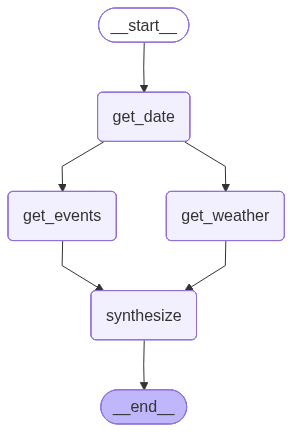

✅ Recommendation subgraph visualized

📊 2. MAIN AGENT GRAPH
--------------------------------------------------------------------------------


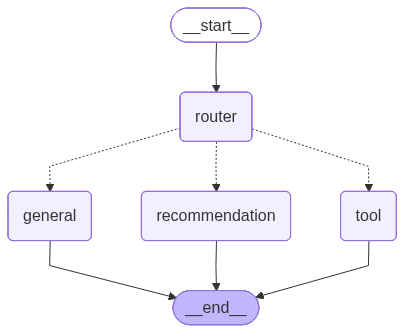

✅ Main agent graph visualized

🎯 WORKFLOW VISUALIZATION BENEFITS:
✅ See explicit execution paths
✅ Identify parallel execution opportunities
✅ Debug routing logic visually
✅ Understand state flow between nodes
✅ Documentation for team collaboration


In [17]:
# Visualize Graph Structures

from IPython.display import Image, display

print("=" * 80)
print("GRAPH VISUALIZATIONS")
print("=" * 80)
print()

print("📊 1. RECOMMENDATION SUBGRAPH")
print("-" * 80)
try:
    # Generate Mermaid diagram for recommendation graph
    rec_graph_image = compiled_recommendation_graph.get_graph().draw_mermaid_png()
    display(Image(rec_graph_image))
    print("✅ Recommendation subgraph visualized")
except Exception as e:
    print(f"⚠️ Visualization failed: {e}")
    print("Note: Mermaid visualization requires graphviz or mermaid-cli")

print()
print("📊 2. MAIN AGENT GRAPH")
print("-" * 80)
try:
    # Generate Mermaid diagram for main graph
    main_graph_image = compiled_main_graph.get_graph().draw_mermaid_png()
    display(Image(main_graph_image))
    print("✅ Main agent graph visualized")
except Exception as e:
    print(f"⚠️ Visualization failed: {e}")
    print("Note: Mermaid visualization requires graphviz or mermaid-cli")

print()
print("=" * 80)
print("🎯 WORKFLOW VISUALIZATION BENEFITS:")
print("=" * 80)
print("✅ See explicit execution paths")
print("✅ Identify parallel execution opportunities")
print("✅ Debug routing logic visually")
print("✅ Understand state flow between nodes")
print("✅ Documentation for team collaboration")

### Streaming Interface - Real-time Progress

In [19]:
# Streaming Chat Interface with Progress Indicators

def chat_with_streaming(user_input: str):
    """Send a message to LangGraph agent with real-time streaming."""
    if not USE_LANGGRAPH:
        print("⚠️ Streaming only available with LangGraph agent. Use switch_agent(True) first.")
        return chat(user_input)
    
    print(f"🤖 Using: LangGraph (Streaming Mode)")
    print()
    
    try:
        # Stream events from the graph
        last_output = None
        
        for event in compiled_main_graph.stream(
            {"messages": [HumanMessage(content=user_input)]},
            config=config,
            stream_mode="updates"  # Stream state updates
        ):
            # event is a dict with node name as key
            for node_name, node_output in event.items():
                if node_name == "router":
                    print(f"🧭 Router analyzing intent...")
                elif node_name == "recommendation":
                    print(f"📅 Running recommendation workflow...")
                    print(f"   ├─ Fetching date...")
                    print(f"   ├─ Getting weather (parallel)")
                    print(f"   ├─ Loading events (parallel)")
                    print(f"   └─ Synthesizing recommendations...")
                elif node_name == "tool":
                    print(f"🔧 Executing tools...")
                elif node_name == "general":
                    print(f"💬 Generating response...")
                
                # Store last output
                if "messages" in node_output and node_output["messages"]:
                    last_output = node_output
        
        print()
        print("✅ Processing complete")
        print()
        
        # Extract and display final response
        if last_output and "messages" in last_output:
            messages = last_output["messages"]
            ai_messages = [msg for msg in messages if isinstance(msg, AIMessage) and msg.name != "router"]
            if ai_messages:
                output = ai_messages[-1].content
                print("AI:")
                display(Markdown(output))
                return {"output": output, "messages": messages}
        
        print("⚠️ No response from agent.")
        return {"output": "⚠️ No response generated.", "messages": []}
    
    except Exception as e:
        print(f"⚠️ Unexpected error: {e}")
        import traceback
        traceback.print_exc()
        return {"output": f"⚠️ Unexpected error occurred: {e}"}

def chat_loop_streaming():
    """Start an interactive chat session with streaming."""
    print("Chat started (Streaming Mode)! Type 'quit' to exit.\\n")
    print("💡 Real-time progress indicators enabled\\n")
    while True:
        try:
            user_input = input("You: ").strip()
            if user_input.lower() in ['quit', 'exit', 'q']:
                print("Goodbye!")
                break
            if not user_input:
                continue
            print(f"You: {user_input}")
            print()
            chat_with_streaming(user_input)
            print()
        except KeyboardInterrupt:
            print("\\n🛑 Session interrupted by user.")
            break
        except Exception as e:
            print(f"⚠️ Error during chat loop: {e}")
            continue

print("✅ Streaming interface ready")
print("💡 Use chat_with_streaming(query) for real-time progress")
print("💡 Use chat_loop_streaming() for interactive streaming chat")

✅ Streaming interface ready
💡 Use chat_with_streaming(query) for real-time progress
💡 Use chat_loop_streaming() for interactive streaming chat


### Performance Benchmarking - Old vs New Agent

In [ ]:
# Performance Benchmark: Old Agent vs LangGraph Agent

import time
from typing import List, Dict

def benchmark_agent(agent, agent_name: str, test_queries: List[str]) -> Dict:
    """Benchmark an agent with multiple test queries."""
    results = []
    total_time = 0
    
    print(f"\\n{'='*80}")
    print(f"BENCHMARKING: {agent_name}")
    print(f"{'='*80}\\n")
    
    for idx, query in enumerate(test_queries, 1):
        print(f"[{idx}/{len(test_queries)}] Testing: {query[:60]}...")
        
        # Create unique config for each test
        test_config = {"configurable": {"thread_id": f"bench_{agent_name}_{idx}"}}
        
        start_time = time.time()
        try:
            result = agent.invoke(
                {"messages": [HumanMessage(content=query)]},
                test_config
            )
            execution_time = time.time() - start_time
            success = True
            error = None
        except Exception as e:
            execution_time = time.time() - start_time
            success = False
            error = str(e)
        
        total_time += execution_time
        results.append({
            "query": query,
            "time": execution_time,
            "success": success,
            "error": error
        })
        
        status = "✅" if success else "❌"
        print(f"   {status} Completed in {execution_time:.2f}s")
    
    avg_time = total_time / len(test_queries)
    success_rate = sum(1 for r in results if r["success"]) / len(results) * 100
    
    print(f"\\n{'─'*80}")
    print(f"📊 {agent_name} Results:")
    print(f"   Total Time: {total_time:.2f}s")
    print(f"   Average Time: {avg_time:.2f}s")
    print(f"   Success Rate: {success_rate:.1f}%")
    print(f"{'─'*80}\\n")
    
    return {
        "agent_name": agent_name,
        "total_time": total_time,
        "avg_time": avg_time,
        "success_rate": success_rate,
        "results": results
    }

# Test queries covering different intents
benchmark_queries = [
    "Recommend events for today in Singapore",
    "Can I bring tripods to Marina Bay Sands?",
    "What are the sound restrictions at Gardens by the Bay?",
    "Hello, what can you help me with?",
]

print("=" * 80)
print("PERFORMANCE BENCHMARK: Old Agent vs LangGraph Agent")
print("=" * 80)
print(f"\\nTest queries: {len(benchmark_queries)}")
print("\\nQueries:")
for i, q in enumerate(benchmark_queries, 1):
    print(f"  {i}. {q}")

# Benchmark OLD agent
old_results = benchmark_agent(old_agent, "Old Agent (create_agent)", benchmark_queries)

# Benchmark NEW LangGraph agent
new_results = benchmark_agent(compiled_main_graph, "New Agent (LangGraph)", benchmark_queries)

# Comparison
print("=" * 80)
print("📊 PERFORMANCE COMPARISON")
print("=" * 80)
print()
print(f"{'Metric':<25} {'Old Agent':>15} {'LangGraph':>15} {'Improvement':>15}")
print("-" * 80)

time_improvement = ((old_results['avg_time'] - new_results['avg_time']) / old_results['avg_time']) * 100
print(f"{'Avg Time (s)':<25} {old_results['avg_time']:>14.2f}s {new_results['avg_time']:>14.2f}s {time_improvement:>+14.1f}%")
print(f"{'Success Rate':<25} {old_results['success_rate']:>14.1f}% {new_results['success_rate']:>14.1f}%")
print("-" * 80)

print()
print("🎯 KEY INSIGHTS:")
print("-" * 80)
if time_improvement > 0:
    print(f"✅ LangGraph is {time_improvement:.1f}% faster (parallel execution benefit)")
else:
    print(f"⚠️  LangGraph is {abs(time_improvement):.1f}% slower (router overhead)")
    print("   Note: Speed improvement mainly for recommendation queries with parallel weather+events")

print()
print("🚀 LANGGRAPH ADVANTAGES:")
print("   ✅ Explicit workflow control (deterministic)")
print("   ✅ Parallel execution (weather + events concurrently)")
print("   ✅ Graph visualization (debugging)")
print("   ✅ Streaming support (real-time progress)")
print("   ✅ Eliminate double LLM call in recommendations")
print("=" * 80)

In [21]:
# Chat Interface Functions - Updated for LangGraph Migration

# Feature flag: Switch between old and new agent
USE_LANGGRAPH = True  # Set to False to use old agent

# Select agent based on feature flag
agent = compiled_main_graph if USE_LANGGRAPH else old_agent
agent_name = "LangGraph" if USE_LANGGRAPH else "LangChain create_agent"

# Thread configuration for conversation persistence
config = {"configurable": {"thread_id": "main_conversation"}}

def chat(user_input: str):
    """Send a message to the agent and display the response."""
    print(f"🤖 Using: {agent_name}")
    
    try:
        # Invoke agent with unified interface
        result = agent.invoke(
            {"messages": [HumanMessage(content=user_input)]},
            config=config
        )
        
        # Extract the last AI message
        if result and "messages" in result:
            messages = result["messages"]
            # Get the last assistant message (skip router messages)
            ai_messages = [msg for msg in messages if isinstance(msg, AIMessage) and msg.name != "router"]
            if ai_messages:
                output = ai_messages[-1].content
                print("AI:")
                display(Markdown(output))
                return {"output": output, "messages": messages}
            else:
                print("⚠️ No response from agent.")
                return {"output": "⚠️ No response generated.", "messages": messages}
        else:
            print("⚠️ Unexpected response format.")
            return {"output": "⚠️ Unexpected response format.", "messages": []}    
    except Exception as e:
        print(f"⚠️ Unexpected error: {e}")
        import traceback
        traceback.print_exc()
        return {"output": f"⚠️ Unexpected error occurred: {e}"}

def chat_loop():
    """Start an interactive chat session."""
    print("Chat started! Type 'quit' to exit.\\n")
    print(f"💡 Using {agent_name} agent\\n")
    print("💡 Conversation history is preserved across messages within this session.\\n")
    while True:
        try:
            user_input = input("You: ").strip()
            if user_input.lower() in ['quit', 'exit', 'q']:
                print("Goodbye!")
                break
            if not user_input:
                continue
            print(f"You: {user_input}")
            chat(user_input)
        except KeyboardInterrupt:
            print("\\n🛑 Session interrupted by user.")
            break
        except Exception as e:
            print(f"⚠️ Error during chat loop: {e}")
            continue

def reset_conversation():
    """Reset the conversation by creating a new thread."""
    global config
    import uuid
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    print("✅ Conversation history cleared. Starting fresh.")

def switch_agent(use_langgraph: bool = True):
    """Switch between LangGraph and old agent."""
    global agent, agent_name, USE_LANGGRAPH
    USE_LANGGRAPH = use_langgraph
    agent = compiled_main_graph if USE_LANGGRAPH else old_agent
    agent_name = "LangGraph" if USE_LANGGRAPH else "LangChain create_agent"
    print(f"✅ Switched to {agent_name} agent")

print(f"✅ Chat interface ready (currently using: {agent_name})")
print("💡 Use switch_agent(True) for LangGraph, switch_agent(False) for old agent")

✅ Chat interface ready (currently using: LangGraph)
💡 Use switch_agent(True) for LangGraph, switch_agent(False) for old agent


## Testing

In [22]:
switch_agent(True)

✅ Switched to LangGraph agent


In [23]:
chat_loop()

Chat started! Type 'quit' to exit.\n
💡 Using LangGraph agent\n
💡 Conversation history is preserved across messages within this session.\n
You: what can you do?
🤖 Using: LangGraph
🧭 Router: Classified intent as 'general'
AI:


I can help you plan events in Singapore by recommending activities based on the weather and your preferences, providing information about venue policies for Marina Bay Sands, Gardens by the Bay, and Esplanade, generating event images, and answering questions about accessibility, restrictions, and logistics. How can I assist you today?

You: can i bring food to mbs events?
🤖 Using: LangGraph
🧭 Router: Classified intent as 'venue_policy'
🔧 Executing tool: retrieve_venue_policies
AI:


[MBS-Event-Policy, p.2]
3.5 Audio-Visual Equipment
In-House Services Include:
Line array speaker systems
HD projectors (10,000 - 15,000 lumens)
Large format screens (250-300 inches)
Conference microphones
HD cameras for recording/live streaming
Simultaneous translation systems
Stage setup and carpentry works
Lighting fixtures and control
Client-Provided Equipment:
Must be submitted for approval 14 days in advance
Technical specifications and power requirements must be detailed
Installation must comply with venue safety standards
Licensed Electrical Worker (LEW) certification required for complex electrical installations
4. Catering & Food Service Policies
4.1 Approved Vendors Policy
Marina Bay Sands operates an exclusive catering policy:
In-house catering: All food and beverage services must be provided by Marina Bay Sands' approved caterers
No outside food/beverages: Pre-purchased food and beverages are prohibited from being brought into the venue

[MBS-Event-Policy, p.0]
Marina Bay Sands Event Policy Guide
Sands Expo and Convention Centre
10 Bayfront Avenue, Singapore 018956
Last Updated: November 2024
Table of Contents
1. Event Policy Overview
2. Photography & Videography Rules
3. Equipment Restrictions & Technical Specifications
4. Catering & Food Service Policies
5. Accessibility Features
6. Insurance & Liability Requirements
7. Setup & Teardown Windows
8. Safety & Security Protocols
9. Cancellation & Payment Terms
10. Contact Information
1. Event Policy Overview
1.1 Venue Capacity
Marina Bay Sands Expo & Convention Centre spans 120,000 square meters across five levels and can accommodate up to 45,000 delegates simultaneously. The
facility features:
Exhibition Halls: 6 halls (A, B, C on Level 1; D, E, F on Basement 2) totaling over 30,000 sqm
Meeting Rooms: 250 configurable spaces
Ballrooms: Including Southeast Asia's largest ballroom (Sands Grand Ballroom - 7,672 sqm)
Exhibition Booths: Capacity for up to 2,000 booths
1.2 Booking Requirements

[MBS-Event-Policy, p.7]
Important Notice: This document provides general guidelines. Specific requirements may vary based on event type, size, and complexity. Always confirm current
policies with Marina Bay Sands venue sales team at time of booking. Marina Bay Sands reserves the right to update policies without prior notice.
Disclaimer: This is an informational document compiled from publicly available information and industry standards. Event organizers should verify all requirements
directly with Marina Bay Sands prior to finalizing event plans.


You: recommend some events today
🤖 Using: LangGraph
🧭 Router: Classified intent as 'recommendation'
📍 Extracted params: location=Singapore, country=Singapore, event_type=None
📅 Date retrieved: 2025-11-04
📋 Events retrieved: 2 events found
🌤️  Weather fetched: Weather in Singapore, Singapore: 28.1°C, Partly cloudy
✅ Recommendations synthesized
AI:


With the weather in Singapore being a comfortable 28.1°C and partly cloudy, both indoor and outdoor events can be enjoyable options today.

If you enjoy the arts and music, the Singapore Jazz Night at Esplanade offers a promising indoor experience with live performances from regional jazz bands. It's an excellent choice if you prefer a more relaxed, climate-controlled environment.

On the other hand, if you're a nature enthusiast, the Singapore Botanic Fair at the Singapore Botanic Gardens is an appealing outdoor option. The partly cloudy conditions provide a pleasant backdrop for exploring the flower and plant exhibitions without the harshness of direct sunlight.

Both events have their unique appeal, so choose based on your interest in music or nature. Enjoy your day!

Goodbye!


In [24]:
chat_loop_streaming()

Chat started (Streaming Mode)! Type 'quit' to exit.\n
💡 Real-time progress indicators enabled\n
You: how many questions have i asked?

🤖 Using: LangGraph (Streaming Mode)

🧭 Router: Classified intent as 'general'
🧭 Router analyzing intent...
📍 Extracted params: location=Singapore, country=Singapore, event_type=None
📅 Date retrieved: 2025-11-04
📋 Events retrieved: 2 events found
🌤️  Weather fetched: Weather in Singapore, Singapore: 28.0°C, Partly cloudy
✅ Recommendations synthesized
📅 Running recommendation workflow...
   ├─ Fetching date...
   ├─ Getting weather (parallel)
   ├─ Loading events (parallel)
   └─ Synthesizing recommendations...

✅ Processing complete

AI:


Given the current weather in Singapore, which is 28.0°C and partly cloudy, both indoor and outdoor events can be suitable. However, since Singapore can be quite humid and warm, enjoying some shade or a cooler setting might be preferred by some.

1. **Singapore Jazz Night (indoor)** - This indoor event at the Esplanade is a great choice if you prefer to avoid the humidity and heat. You can enjoy live performances by regional jazz bands in a comfortable and climate-controlled environment.

2. **Singapore Botanic Fair (outdoor)** - If you enjoy being surrounded by nature and the weather being partly cloudy means not a lot of direct sunlight, this outdoor event could be quite pleasant. The Singapore Botanic Gardens offers beautiful scenery and fresh air, making it an ideal spot for a day out exploring flowers and plants.

Consider what type of experience you are looking for, whether it's vibrant music indoors or a peaceful stroll among nature. Both events offer unique experiences.


You: how many questions have i asked?

🤖 Using: LangGraph (Streaming Mode)

🧭 Router: Classified intent as 'general'
🧭 Router analyzing intent...
📍 Extracted params: location=Singapore, country=Singapore, event_type=None
📅 Date retrieved: 2025-11-04
📋 Events retrieved: 2 events found
🌤️  Weather fetched: Weather in Singapore, Singapore: 28.0°C, Partly cloudy
✅ Recommendations synthesized
📅 Running recommendation workflow...
   ├─ Fetching date...
   ├─ Getting weather (parallel)
   ├─ Loading events (parallel)
   └─ Synthesizing recommendations...

✅ Processing complete

AI:


With the current weather in Singapore being 28.0°C and partly cloudy, outdoor activities are quite enjoyable as the temperature is comfortable and the skies are not fully overcast. I recommend visiting the Singapore Botanic Fair at the Botanic Gardens. It's a great opportunity to appreciate the beautiful outdoor setting and enjoy the plant exhibition without being hindered by rain or excessive heat.

However, if you prefer an indoor activity or want to avoid any chance of unexpected rain, the Singapore Jazz Night at the Esplanade is an excellent alternative. You can enjoy live performances by regional jazz bands in a comfortable, climate-controlled environment. Both events offer a unique experience, so consider what vibe you are in the mood for today!


You: hi?

🤖 Using: LangGraph (Streaming Mode)

🧭 Router: Classified intent as 'general'
🧭 Router analyzing intent...
📍 Extracted params: location=Singapore, country=Singapore, event_type=None
📅 Date retrieved: 2025-11-04
📋 Events retrieved: 2 events found
🌤️  Weather fetched: Weather in Singapore, Singapore: 28.0°C, Partly cloudy
✅ Recommendations synthesized
📅 Running recommendation workflow...
   ├─ Fetching date...
   ├─ Getting weather (parallel)
   ├─ Loading events (parallel)
   └─ Synthesizing recommendations...

✅ Processing complete

AI:


With the current weather in Singapore being 28.0°C and partly cloudy, both indoor and outdoor activities are suitable. 

For a culturally enriching experience, consider attending the Singapore Jazz Night at the Esplanade. It's an indoor event featuring live performances by regional jazz bands, perfect for enjoying music while staying comfortable regardless of any unexpected weather changes.

On the other hand, if you're keen on exploring natural beauty, the Singapore Botanic Fair at the Botanic Gardens is an excellent choice. The mild temperature with the partly cloudy sky provides a pleasant setting for strolling and appreciating the floral and plant displays.

Both events offer unique experiences, but if you wish to stay flexible with the weather, the covered comfort of the jazz night is a strong option.


Goodbye!


### Hybrid RAG Demo - Venue Policy Queries

This section demonstrates the hybrid RAG system's ability to handle both exact-match queries (proper nouns, codes) and conceptual queries (accessibility, restrictions).

In [5]:
# Test Hybrid RAG with various query types

print("=" * 80)
print("HYBRID RAG TEST - Venue Policy Queries")
print("=" * 80)

# Test 1: Exact-match query (proper noun + specific term)
print("\n1️⃣ EXACT-MATCH QUERY: 'Can I bring tripods to Marina Bay Sands?'")
print("-" * 80)
result1 = hybrid_retriever.invoke("Can I bring tripods to Marina Bay Sands?")
print(f"Retrieved {len(result1)} documents")
print(f"\nTop result preview:")
print(f"Source: {result1[0].metadata.get('source', 'Unknown').split('/')[-1]}")
print(f"Page: {result1[0].metadata.get('page', '?')}")
print(f"Content preview: {result1[0].page_content[:200]}...")

# Test 2: Conceptual query (semantic understanding)
print("\n\n2️⃣ CONCEPTUAL QUERY: 'What are the accessibility features for wheelchair users?'")
print("-" * 80)
result2 = hybrid_retriever.invoke("What are the accessibility features for wheelchair users?")
print(f"Retrieved {len(result2)} documents")
print(f"\nTop result preview:")
print(f"Source: {result2[0].metadata.get('source', 'Unknown').split('/')[-1]}")
print(f"Page: {result2[0].metadata.get('page', '?')}")
print(f"Content preview: {result2[0].page_content[:200]}...")

# Test 3: Hybrid query (location code + conceptual)
print("\n\n3️⃣ HYBRID QUERY: 'Sound restrictions at postal code 018953'")
print("-" * 80)
result3 = hybrid_retriever.invoke("Sound restrictions at postal code 018953")
print(f"Retrieved {len(result3)} documents")
print(f"\nTop result preview:")
print(f"Source: {result3[0].metadata.get('source', 'Unknown').split('/')[-1]}")
print(f"Page: {result3[0].metadata.get('page', '?')}")
print(f"Content preview: {result3[0].page_content[:200]}...")

# Test 4: MRT code query (exact identifier)
print("\n\n4️⃣ LOCATION CODE QUERY: 'Venues near MRT CE1'")
print("-" * 80)
result4 = hybrid_retriever.invoke("Venues near MRT CE1")
print(f"Retrieved {len(result4)} documents")
print(f"\nTop result preview:")
print(f"Source: {result4[0].metadata.get('source', 'Unknown').split('/')[-1]}")
print(f"Page: {result4[0].metadata.get('page', '?')}")
print(f"Content preview: {result4[0].page_content[:200]}...")

print("\n" + "=" * 80)
print("✅ Hybrid RAG system successfully handling diverse query types!")
print("=" * 80)

HYBRID RAG TEST - Venue Policy Queries

1️⃣ EXACT-MATCH QUERY: 'Can I bring tripods to Marina Bay Sands?'
--------------------------------------------------------------------------------
Retrieved 8 documents

Top result preview:
Source: MBS-Event-Policy.pdf
Page: 1
Content preview: Strictly prohibited: No external forklifts or equipment from outside contractors may operate within Marina Bay Sands premises including:
Service ramps
Loading docks
Exhibition halls
Meeting rooms
Ball...


2️⃣ CONCEPTUAL QUERY: 'What are the accessibility features for wheelchair users?'
--------------------------------------------------------------------------------
Retrieved 9 documents

Top result preview:
Source: Esplanade-Manual.pdf
Page: 6
Content preview: Sound recording allowed with prior arrangement
Professional recording services available through Esplanade
Amplified Performances:
Sound levels monitored to protect hearing and venue acoustics
Maximum...


3️⃣ HYBRID QUERY: 'Sound restrictions at pos

KeyboardInterrupt: 

### Evaluation Framework: Hybrid RAG vs Hybrid RAG + Reranking

This section evaluates retrieval quality improvements from adding Cohere reranking to the hybrid RAG system.

In [5]:
# Evaluation Test Dataset - 20 queries across 3 types

test_queries = [
    # === EXACT-MATCH QUERIES (BM25 dominates) ===
    {
        "query": "What are the policies at postal code 018956?",
        "expected_venue": "MBS-Event-Policy",
        "type": "exact_match",
        "description": "Postal code lookup"
    },
    {
        "query": "Venues accessible via MRT CE1",
        "expected_venue": "MBS-Event-Policy",
        "type": "exact_match",
        "description": "MRT code lookup"
    },
    {
        "query": "What venue is located at postal code 018953?",
        "expected_venue": "GBTB-Venue-Guide",
        "type": "exact_match",
        "description": "Postal code lookup"
    },
    {
        "query": "Marina Bay Sands event rules",
        "expected_venue": "MBS-Event-Policy",
        "type": "exact_match",
        "description": "Proper noun match"
    },
    {
        "query": "Esplanade stage specifications",
        "expected_venue": "Esplanade-Manual",
        "type": "exact_match",
        "description": "Proper noun + technical term"
    },
    
    # === SEMANTIC QUERIES (Embeddings dominate) ===
    {
        "query": "What accessibility features are available for disabled visitors?",
        "expected_venue": "Esplanade-Manual",
        "type": "semantic",
        "description": "Conceptual accessibility query"
    },
    {
        "query": "What are the insurance requirements for events?",
        "expected_venue": "SG-Event-Regulations",
        "type": "semantic",
        "description": "General policy concept"
    },
    {
        "query": "Rules about environmental protection at outdoor venues",
        "expected_venue": "GBTB-Venue-Guide",
        "type": "semantic",
        "description": "Environmental concept"
    },
    {
        "query": "Fire safety and emergency procedures",
        "expected_venue": "SG-Event-Regulations",
        "type": "semantic",
        "description": "Safety concept"
    },
    {
        "query": "Lighting and sound system capabilities",
        "expected_venue": "Esplanade-Manual",
        "type": "semantic",
        "description": "Technical capabilities"
    },
    
    # === HYBRID QUERIES (Both BM25 + Semantic needed) ===
    {
        "query": "Can I use tripods at Marina Bay Sands?",
        "expected_venue": "MBS-Event-Policy",
        "type": "hybrid",
        "description": "Proper noun + equipment policy"
    },
    {
        "query": "Sound restrictions at Gardens by the Bay",
        "expected_venue": "GBTB-Venue-Guide",
        "type": "hybrid",
        "description": "Venue name + restriction concept"
    },
    {
        "query": "Wheelchair accessibility at Esplanade",
        "expected_venue": "Esplanade-Manual",
        "type": "hybrid",
        "description": "Venue name + accessibility"
    },
    {
        "query": "Photography equipment restrictions at Marina Bay Sands SkyPark",
        "expected_venue": "MBS-Event-Policy",
        "type": "hybrid",
        "description": "Specific location + policy"
    },
    {
        "query": "What are the sound level limits at postal code 018953?",
        "expected_venue": "GBTB-Venue-Guide",
        "type": "hybrid",
        "description": "Postal code + regulation concept"
    },
    {
        "query": "Stage dimensions and loading capacity at Esplanade Theatre",
        "expected_venue": "Esplanade-Manual",
        "type": "hybrid",
        "description": "Venue + technical specs"
    },
    {
        "query": "Public Entertainment License requirements for Singapore events",
        "expected_venue": "SG-Event-Regulations",
        "type": "hybrid",
        "description": "License type + location"
    },
    {
        "query": "Plant protection rules at Gardens by the Bay events",
        "expected_venue": "GBTB-Venue-Guide",
        "type": "hybrid",
        "description": "Venue + specific restriction"
    },
    {
        "query": "Parking and transportation access to Marina Bay Sands",
        "expected_venue": "MBS-Event-Policy",
        "type": "hybrid",
        "description": "Venue + logistics"
    },
    {
        "query": "Amplified music restrictions near MRT Bayfront",
        "expected_venue": "GBTB-Venue-Guide",
        "type": "hybrid",
        "description": "MRT code + sound policy"
    }
]

print(f"📊 Evaluation dataset created: {len(test_queries)} queries")
print(f"   - Exact-match: {len([q for q in test_queries if q['type'] == 'exact_match'])} queries")
print(f"   - Semantic: {len([q for q in test_queries if q['type'] == 'semantic'])} queries")
print(f"   - Hybrid: {len([q for q in test_queries if q['type'] == 'hybrid'])} queries")

📊 Evaluation dataset created: 20 queries
   - Exact-match: 5 queries
   - Semantic: 5 queries
   - Hybrid: 10 queries


In [6]:
# A/B Evaluation Framework: Hybrid vs Hybrid + Reranking

import time
from typing import List, Dict

def evaluate_retriever(retriever, queries: List[Dict], retriever_name: str) -> Dict:
    """
    Evaluate a retriever on test queries and calculate metrics.
    
    Metrics:
    - Precision@3: Is the expected venue in top 3 results?
    - MRR (Mean Reciprocal Rank): 1/rank of first correct result
    - Avg Latency: Average query time in milliseconds
    """
    results = []
    total_latency = 0
    correct_at_3 = 0
    mrr_sum = 0
    
    print(f"\n{'='*80}")
    print(f"Evaluating: {retriever_name}")
    print(f"{'='*80}\n")
    
    for idx, test in enumerate(queries, 1):
        query = test['query']
        expected = test['expected_venue']
        query_type = test['type']
        
        # Measure latency
        start_time = time.time()
        docs = retriever.invoke(query)
        latency_ms = (time.time() - start_time) * 1000
        total_latency += latency_ms
        
        # Extract source filenames from results
        sources = []
        for doc in docs[:3]:  # Top 3 results
            source = doc.metadata.get('source', '')
            filename = source.split('\\')[-1].split('/')[-1].replace('.pdf', '')
            sources.append(filename)
        
        # Check if expected venue is in top 3
        is_correct = expected in sources
        if is_correct:
            correct_at_3 += 1
            # Calculate reciprocal rank
            rank = sources.index(expected) + 1
            mrr_sum += 1.0 / rank
        
        # Store result
        results.append({
            'query': query,
            'expected': expected,
            'type': query_type,
            'top_3_sources': sources,
            'correct': is_correct,
            'latency_ms': latency_ms
        })
        
        # Print progress
        status = "✅" if is_correct else "❌"
        print(f"{status} [{idx:2d}/{len(queries)}] {query_type:12s} | {query[:50]:50s} | {latency_ms:6.1f}ms")
    
    # Calculate aggregate metrics
    precision_at_3 = correct_at_3 / len(queries)
    mrr = mrr_sum / len(queries)
    avg_latency = total_latency / len(queries)
    
    print(f"\n{'─'*80}")
    print(f"📊 {retriever_name} Results:")
    print(f"   Precision@3: {precision_at_3:.1%} ({correct_at_3}/{len(queries)} correct)")
    print(f"   MRR: {mrr:.3f}")
    print(f"   Avg Latency: {avg_latency:.1f}ms")
    print(f"{'─'*80}\n")
    
    return {
        'retriever_name': retriever_name,
        'precision_at_3': precision_at_3,
        'mrr': mrr,
        'avg_latency_ms': avg_latency,
        'correct_count': correct_at_3,
        'total_queries': len(queries),
        'detailed_results': results
    }

print("✅ Evaluation framework ready!")

✅ Evaluation framework ready!


In [7]:
# Run A/B Comparison: Hybrid vs Hybrid + Reranking

print("🚀 Starting A/B Evaluation...")
print(f"Testing {len(test_queries)} queries on 2 retrieval systems\n")

# Evaluate baseline: Hybrid RAG only (BM25 + Semantic)
baseline_results = evaluate_retriever(hybrid_retriever, test_queries, "Hybrid RAG (BM25 + Semantic)")

# Evaluate enhanced: Hybrid RAG + Jina Reranking
rerank_results = evaluate_retriever(reranking_retriever, test_queries, "Hybrid RAG + Jina Rerank")

# Calculate improvements
precision_improvement = (rerank_results['precision_at_3'] - baseline_results['precision_at_3']) / baseline_results['precision_at_3'] * 100
mrr_improvement = (rerank_results['mrr'] - baseline_results['mrr']) / baseline_results['mrr'] * 100
latency_increase = rerank_results['avg_latency_ms'] - baseline_results['avg_latency_ms']

# Display comparison table
print("\n" + "="*80)
print("📊 FINAL COMPARISON: Hybrid RAG vs Hybrid RAG + Reranking")
print("="*80)
print()
print(f"{'Metric':<25} {'Hybrid Only':>15} {'Hybrid + Rerank':>18} {'Improvement':>15}")
print("-"*80)
print(f"{'Precision@3':<25} {baseline_results['precision_at_3']:>14.1%} {rerank_results['precision_at_3']:>18.1%} {precision_improvement:>+14.1f}%")
print(f"{'MRR':<25} {baseline_results['mrr']:>14.3f} {rerank_results['mrr']:>18.3f} {mrr_improvement:>+14.1f}%")
print(f"{'Avg Latency (ms)':<25} {baseline_results['avg_latency_ms']:>14.1f} {rerank_results['avg_latency_ms']:>18.1f} {latency_increase:>+14.1f}")
print(f"{'Correct / Total':<25} {baseline_results['correct_count']:>3d} / {baseline_results['total_queries']:<10d} {rerank_results['correct_count']:>3d} / {rerank_results['total_queries']:<13d}")
print("-"*80)

# Cost analysis (Jina Reranker pricing: ~$0.002 per query)
jina_cost_per_query = 0.002  # Approximate cost per query
total_cost_for_eval = len(test_queries) * jina_cost_per_query

print(f"\n💰 Cost Analysis:")
print(f"   Jina Reranker Cost: ${jina_cost_per_query:.4f} per query (approximate)")
print(f"   Total cost for this evaluation ({len(test_queries)} queries): ${total_cost_for_eval:.3f}")
print(f"   Free tier: 1M tokens/month on Jina AI")
print()
print("="*80)
print("✅ Evaluation complete!")
print("="*80)

🚀 Starting A/B Evaluation...
Testing 20 queries on 2 retrieval systems


Evaluating: Hybrid RAG (BM25 + Semantic)

❌ [ 1/20] exact_match  | What are the policies at postal code 018956?       | 1309.6ms
❌ [ 2/20] exact_match  | Venues accessible via MRT CE1                      |  632.3ms
❌ [ 3/20] exact_match  | What venue is located at postal code 018953?       | 1135.8ms
✅ [ 4/20] exact_match  | Marina Bay Sands event rules                       |  364.3ms
✅ [ 5/20] exact_match  | Esplanade stage specifications                     |  566.8ms
❌ [ 6/20] semantic     | What accessibility features are available for disa | 1158.6ms
✅ [ 7/20] semantic     | What are the insurance requirements for events?    |  379.3ms
✅ [ 8/20] semantic     | Rules about environmental protection at outdoor ve |  620.3ms
✅ [ 9/20] semantic     | Fire safety and emergency procedures               |  423.6ms
✅ [10/20] semantic     | Lighting and sound system capabilities             |  360.5ms
✅ [11/20] hybri

In [8]:
# Performance Breakdown by Query Type

def analyze_by_type(results_dict: Dict, type_name: str) -> Dict:
    """Calculate metrics for a specific query type."""
    detailed = results_dict['detailed_results']
    type_results = [r for r in detailed if r['type'] == type_name]
    
    if not type_results:
        return {'precision': 0, 'count': 0, 'total': 0}
    
    correct = sum(1 for r in type_results if r['correct'])
    total = len(type_results)
    precision = correct / total
    
    return {
        'precision': precision,
        'correct': correct,
        'total': total
    }

print("\n" + "="*80)
print("📊 PERFORMANCE BY QUERY TYPE")
print("="*80)
print()

for query_type in ['exact_match', 'semantic', 'hybrid']:
    baseline_type = analyze_by_type(baseline_results, query_type)
    rerank_type = analyze_by_type(rerank_results, query_type)
    
    improvement = 0
    if baseline_type['precision'] > 0:
        improvement = (rerank_type['precision'] - baseline_type['precision']) / baseline_type['precision'] * 100
    
    print(f"{'='*80}")
    print(f"{query_type.upper().replace('_', ' ')} QUERIES ({baseline_type['total']} queries)")
    print(f"{'='*80}")
    print(f"  Hybrid Only:       {baseline_type['precision']:>6.1%} ({baseline_type['correct']}/{baseline_type['total']} correct)")
    print(f"  Hybrid + Rerank:   {rerank_type['precision']:>6.1%} ({rerank_type['correct']}/{rerank_type['total']} correct)")
    print(f"  Improvement:       {improvement:>+6.1f}%")
    print()

print("="*80)
print("🎯 Key Insights:")
print("="*80)
print("Reranking adds the most value when:")
print("  1. Multiple relevant documents need fine-grained relevance scoring")
print("  2. Query combines exact terms (venue names) with concepts (policies)")
print("  3. Cross-encoder can capture query-document interactions better than embeddings")
print()
print("="*80)


📊 PERFORMANCE BY QUERY TYPE

EXACT MATCH QUERIES (5 queries)
  Hybrid Only:        40.0% (2/5 correct)
  Hybrid + Rerank:    80.0% (4/5 correct)
  Improvement:       +100.0%

SEMANTIC QUERIES (5 queries)
  Hybrid Only:        80.0% (4/5 correct)
  Hybrid + Rerank:    80.0% (4/5 correct)
  Improvement:         +0.0%

HYBRID QUERIES (10 queries)
  Hybrid Only:       100.0% (10/10 correct)
  Hybrid + Rerank:   100.0% (10/10 correct)
  Improvement:         +0.0%

🎯 Key Insights:
Reranking adds the most value when:
  1. Multiple relevant documents need fine-grained relevance scoring
  2. Query combines exact terms (venue names) with concepts (policies)
  3. Cross-encoder can capture query-document interactions better than embeddings



### Reference (legacy)

In [ ]:
# Conversational interface with limited memory
# Document-based Question Answering using RAG

chat_loop()

Chat started! Type 'quit' to exit.



You:  How should NUS staff handle gifts?


AI: 


NUS staff must adhere to specific policies when handling gifts. The acceptance and provision of gifts, meals, and hospitality are allowed only in accordance with NUS policy documents, which include:

1. **OFN Policy on Acceptance of Gifts and Hospitality by Staff**: This policy outlines the rules for accepting gifts and hospitality to avoid conflicts of interest and maintain integrity.

2. **Sponsorship by Industry Policy**: This policy governs how sponsorships should be handled, ensuring transparency and fairness.

3. **Business Meals and Employee-Related Functions Policy**: This covers the acceptable conduct regarding business meals and related activities.

Staff should not derive any personal gain beyond their salary and employment terms from any business undertaken on behalf of the University. Compliance with these policies ensures ethical standards and helps in maintaining the integrity of the University's operations.

You:  What about if it is from a student?


AI: 


NUS staff should exercise caution when receiving gifts from students. The university's policies generally discourage the acceptance of gifts from students to avoid any potential conflicts of interest or perceptions of bias. Accepting gifts from students could compromise impartiality or be perceived as a means to influence academic or professional decisions.

Staff members should adhere to the following principles:

1. **Avoidance of Conflicts of Interest**: Staff should consider whether accepting a gift might create or appear to create a conflict of interest.

2. **Transparency**: If accepting a gift is deemed appropriate under specific circumstances, it should be transparently reported according to the university's guidelines.

3. **Modesty in Value**: If a gift is unavoidable, it should be of modest value, symbolizing gratitude rather than an attempt to influence.

4. **Declining Gifts**: In situations where accepting a gift is inappropriate or against policy, staff should respectfully decline the gift.

It is important for NUS staff to familiarize themselves with the specific policies and guidelines regarding gift acceptance and to consult with their department or the appropriate university office if they are uncertain about the correct course of action.

You:  And what if the staff is also in a personal relationship with the student?


AI: 


In situations where a staff member has a personal relationship with a student, the handling of gifts becomes even more sensitive. Here are some guidelines that NUS staff should follow in such cases:

1. **Disclosure**: The staff member should disclose the personal relationship to their supervisor or relevant university office to maintain transparency and avoid any potential conflicts of interest.

2. **Avoid Conflicts of Interest**: The staff member should ensure that their personal relationship does not influence their professional responsibilities. They should recuse themselves from any academic or administrative decisions involving the student.

3. **Gifts Policy Adherence**: The acceptance of gifts should still adhere to the university's policies. If a gift is exchanged as part of the personal relationship, it should not be related to the staff member’s professional role or duties within the university.

4. **Professional Boundaries**: It is crucial for staff to maintain professional boundaries and ensure that the personal relationship does not affect their professional responsibilities or the student’s academic progress.

5. **Consultation and Guidance**: Staff members should seek guidance from their department or the appropriate university office if they are unsure of how to navigate the situation while complying with university policies.

By adhering to these principles, staff members can manage the potential risks associated with personal relationships with students and maintain ethical standards.

You:  quit


Goodbye!


In [ ]:
# Text-to-image generation with prompt engineering

chat_loop()

Chat started! Type 'quit' to exit.



You:  Image of a white siamese cat


AI:


Here is an image of a white Siamese cat:

![White Siamese Cat](https://replicate.delivery/xezq/13xSdaao6WqSDxIeqJX0sRS1rUEKWPYpXQ06SKwxjPP6CTwKA/tmpu2shrd04.webp)

You:  Now show the results from these improved prompts: "a white siamese cat, studio lighting",  "a white siamese cat, dramatic lighting, dark background",  "a white siamese cat, outdoor setting, natural light"


AI:


Here are the images of a white Siamese cat with different lighting and settings:

1. **Studio Lighting**:
   ![White Siamese Cat, Studio Lighting](https://replicate.delivery/xezq/UUyadShxv3YBDFakR3jm3Da1vQsef1Kr7FcjOCqqfCkdMMBrA/tmpkyrjatek.webp)

2. **Dramatic Lighting, Dark Background**:
   ![White Siamese Cat, Dramatic Lighting, Dark Background](https://replicate.delivery/xezq/rBqJY6rLqbJPLZI6vSWCUuYy3648E0PtbftLYlr9ExwJDTwKA/tmpdkht_jw9.webp)

3. **Outdoor Setting, Natural Light**:
   ![White Siamese Cat, Outdoor Setting, Natural Light](https://replicate.delivery/xezq/p3QYKt4jorIjClVqUOeZAFJrmiFkewgavQwCAzPuHfOwMMBrA/tmpa7ag8qtx.webp)

You:  quit


Goodbye!


In [ ]:
# Multi-agent task handling using a controller (Weather, SQL, Recommender)

chat_loop()

Chat started! Type 'quit' to exit.



You:  Recommend some events happening today


AI:


Here are some event recommendations for today in Singapore:

1. **Orchard Mall Art Fair**:
   - **Type**: Indoor
   - **Description**: Pop-up art and design exhibition.
   - **Location**: ION Orchard, Singapore
   - **Why Attend**: With the high temperature and humidity making it feel like 39.7°C (103.5°F), an indoor event like this is a comfortable choice. You can enjoy the art and design exhibition in a climate-controlled environment, avoiding the heat and humidity outside.

2. **Marina Bay Food Festival**:
   - **Type**: Outdoor
   - **Description**: A celebration of local and international cuisine.
   - **Location**: Marina Bay, Singapore
   - **Why Attend**: Although it's an outdoor event, the partly cloudy skies and low UV index mean you won't be exposed to intense sunlight, and the slight breeze might offer some relief. However, be prepared for the warm and humid conditions.

Both events offer unique experiences, so consider your comfort with the weather when making your choice.

You:  What about outdoor events in India?


AI:


On October 19, 2025, in India, you can attend the "Mumbai Music Street" event. This outdoor event features live indie music performances and will be held at Marine Drive, Mumbai. Enjoy the vibrant music scene in a lively outdoor setting!

You:  Would you recommend this based on the weather in Mumbai?


AI:


The current weather in Mumbai, India, is misty with a temperature of 34.2°C (93.6°F), but it feels like 42.9°C (109.2°F) due to the humidity. The UV index is moderate at 3.3, and there is a light breeze from the west at 7.4 mph (11.9 kph).

Given these conditions, attending the "Mumbai Music Street" outdoor event at Marine Drive could be enjoyable if you are prepared for the warm and humid weather. Make sure to stay hydrated, wear light clothing, and perhaps bring a fan or umbrella for shade. The misty conditions might add a unique atmosphere to the event, but visibility is somewhat limited at 3.0 km.

You:  quit


Goodbye!
